<a href="https://colab.research.google.com/github/daphnecor/advanced_machine_learning/blob/main/Adv_ml_week2_ElongatedGaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Chain Monte Carlo sampling: Elongated Gaussian




In [ ]:
#@title Dependencies
import matplotlib.pyplot as plt
from autograd import grad
import scipy
from scipy import stats
import seaborn as sns
import numpy as np
import time
import copy

sns.set_style('white')
cmap = sns.dark_palette("#69d", reverse=True, as_cmap=True)

Parameters

In [ ]:
A = np.array([[250.25, -249.75], [-249.75, 250.25]])
sigmas = np.array([1, 1])

Ainv = scipy.linalg.inv(A)
Px_rv = stats.multivariate_normal(mean=None, cov=Ainv)

x1, x2 = np.mgrid[-1:1:.01, -1:1:.01]
pos = np.empty(x1.shape + (2,))
pos[:, :, 0] = x1; pos[:, :, 1] = x2

Px = lambda x: np.exp(-(1/2) * np.inner(np.inner(x, A), x)) # define target distribution

## 0. Figures 

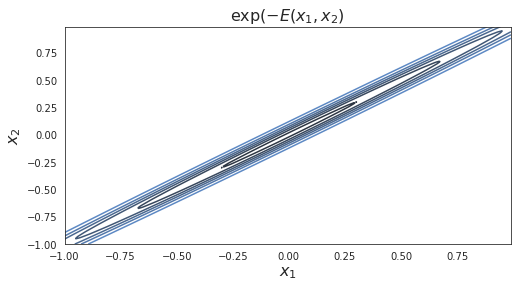

In [ ]:
#@title The target distribution
fig, ax = plt.subplots(1,1, figsize = (8, 4))
ax.set_title(r'$\exp(-E(x_1, x_2)$', fontsize=16)
ax.contour(x1, x2, Px_rv.pdf(pos), cmap=cmap);
ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16);

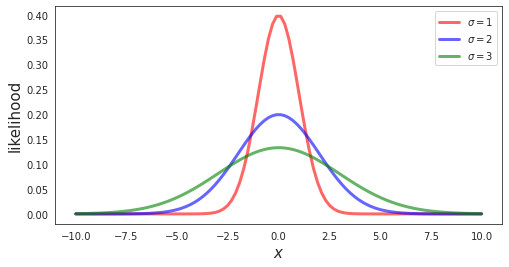

In [ ]:
#@title One dimensional gaussian
x = np.linspace(-10, 10, 100)
normal1 = stats.norm.pdf(x, 0, 1)
normal2 = stats.norm.pdf(x, 0, 2)
normal3 = stats.norm.pdf(x, 0, 3)

# figure
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(x, normal1,'r-', lw=3, alpha=0.6, label=r'$\sigma = 1$');
ax.plot(x, normal2,'b-', lw=3, alpha=0.6, label=r'$\sigma = 2$');
ax.plot(x, normal3,'g-', lw=3, alpha=0.6, label=r'$\sigma = 3$');
ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel('likelihood', fontsize=15)
ax.legend();

## 1.1 Metropolis Hastings

In [ ]:
def metropolis(Px, sigmas, R, iterations, timing=False, minutes=1):
  '''Metropolis Hastings algorithm (MCMC)

  Parameters
  ----------
  Px: target density as defined in the assingment

  R: sample dimension

  iterations: number of times we want to draw samples

  timing: if set to True run for specified time (in minutes) rather than number of iterations

  minutes: allowed run time (minutes)

  Returns
  -------
  samples: the accepted samples 

  x0: starting sample

  acceptance rate: num of accepted samples
  '''
  acceptance = 0

  x_r = stats.uniform.rvs(size=2) # random starting values
  x0 = x_r
  samples = np.zeros((iterations, R))

  if timing == True:
    print('yes')
    samples = []

    t_end = time.time() + 60 * minutes 
    while time.time() < t_end:

      x_prime = x_r + np.random.normal(size=R, scale=sigmas) 
      a = Px(x_prime) / Px(x_r) # calculate acceptance rate 

      if np.random.rand() < a:
        x_r = x_prime # accept x' as the new state 
        acceptance += 1
      samples.append(x_r)


  else:

    for r in range(iterations):

      x_prime = x_r + np.random.normal(size=R, scale=sigmas) 
      a = Px(x_prime) / Px(x_r) # calculate acceptance rate 

      if np.random.rand() < a:
        x_r = x_prime # accept x' as the new state 
        acceptance += 1
      samples[r] = x_r
  
  acceptance_rate = acceptance/len(samples) 

  return samples, x0, acceptance_rate

varying the width of the proposal distribution

In [ ]:
sig1 = np.arange(0.01, 3.01, 0.1)
sig2 = np.arange(0.01, 3.01, 0.1)
acceptance_rates = []
iters = [100, 1000, 10000]

for i in range(len(sig1)):

  sigmas = np.array([sig1[i], sig2[i]])

  samples, x0, acceptance_ratio = metropolis(Px, sigmas=sigmas, R=2, iterations=1000)
  # #print(f'if sigma = {sigmas[0]} {acceptance_ratio} of the samples is accepted and time is {duration}')
  acceptance_rates.append(acceptance_ratio)
  # p = sns.jointplot(samples[:, 0], samples[:, 1], xlim=[-3,3], ylim=[-3,3])
  # p.fig.suptitle(f'$\sigma =${sigmas[0]}', fontsize=16, y=1.08)
  # p.fig.tight_layout();
  # p.set_axis_labels(r'$x_1$', r'$x_2$', fontsize=16)
  # p.ax_joint.scatter(x0[0], x0[1], color ='darkgreen', marker='x', s=100)
  # p.plot_marginals(sns.rugplot, color='r', height=-.15, clip_on=False)

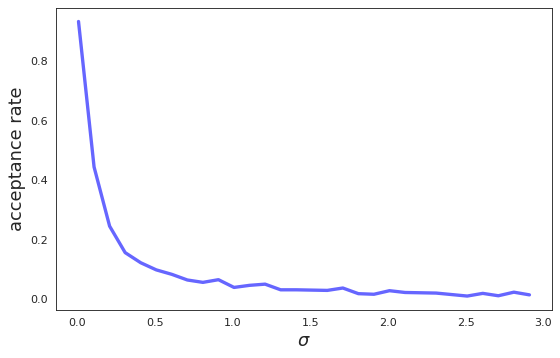

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8, 5), dpi=80)

ax.plot(sig1, acceptance_rates, 'b-', lw=3, alpha=0.6,);
ax.set_xlabel(r'$\sigma$', fontsize=16)
ax.set_ylabel('acceptance rate', fontsize=16);

## 1.2 Hamilton Monte Carlo


In [ ]:
A = np.array([[250.25, -249.75], [-249.75, 250.25]]) 

def findE(x):
  '''set objective function
  '''
  return (1/2) * x.T @ A @ x

def gradE(x):
  '''set gradient using x (position)
  '''
  return grad(findE)(x)

def AgradE(x):
  '''set gradient analytically
  '''
  return A @ x

In [ ]:
def hamiltonian_monte_carlo(num_samples, initial_position, findE, gradE, tau=19, epsilon=0.055, mu=0, sigma=1, timing=False, minutes=1):
  '''Hamiltonian Monte Carlo sampling

  Parameters
  ----------

  num_samples: number of samples to generate

  initial_position: initial guess for x 

  gradE: dE/dx function

  findE: definition of energy

  tau: number of integration steps

  epsilon: size of the integration step

  mu, sigma: initialise the normal distribution for the momentum p

  timing: if set to True run for a specified time instead of num_samples (overrides num_samples)

  minutes: allowed run time

  Returns
  -------
  samples: the generated accepted samples 

  acceptance rate: % total samples accepted

  initial position: x0 for plotting
  '''


  # ----------- (1) Setup ---------- #
  momentum_distrib = stats.norm(mu, sigma)  # distribution for sampling momentum
  samples = [initial_position]              # store initial position in list           
  accepted = 0
  dim = len(initial_position)

  x = initial_position
  E = findE(x)
  dE = gradE(x) 

  if timing == True:
    t_end = time.time() + 60 * minutes 
    while time.time() < t_end:

      x = copy.deepcopy(x)                     # store deepcopies (otherwise arrays are overridden)
      dE = copy.deepcopy(dE)

      p = momentum_distrib.rvs(size=dim)       # p is a two dimensional sample from the standard normal
      H = np.dot(p, p) / 2.0 + E               # evaluate H(x,p)
    
      # ------- (2) Leapfrog step ------- #
      x_new, p, dE_new = leapfrog_integration(x, p, dE, tau, epsilon)
      E_new = findE(x_new)                     # find new value of H
      H_new = (np.dot(p, p) / 2.0) + E_new
      dH = H_new - H   

      # ------- (3) Acceptance ---------- #
      if dH < 0.0 or stats.uniform.rvs() < np.exp(-dH):   
        samples.append(x_new)
        x = x_new
        dE = dE_new
        E = E_new
        accepted += 1.0
      else:
        samples.append(x)

  else: # run for specified number of iterations

    for n in range(num_samples):
      x = copy.deepcopy(x)                     # store deepcopies (otherwise arrays are overridden)
      dE = copy.deepcopy(dE)

      p = momentum_distrib.rvs(size=dim)       # p is a two dimensional sample from the standard normal
      H = np.dot(p, p) / 2.0 + E               # evaluate H(x,p)
    
      # ------- (2) Leapfrog step ------- #
      x_new, p, dE_new = leapfrog_integration(x, p, dE, tau, epsilon)
      E_new = findE(x_new)                     # find new value of H
      H_new = (np.dot(p, p) / 2.0) + E_new
      dH = H_new - H         

      # ------- (3) Acceptance ---------- #
      if dH < 0.0 or stats.uniform.rvs() < np.exp(-dH):   
        samples.append(x_new)
        x = x_new
        dE = dE_new
        E = E_new
        accepted += 1.0
      else:
        samples.append(x)

  acceptance_rate = accepted/len(samples)   # percentage of accepted samples

  return np.array(samples[1:]), acceptance_rate, initial_position

In [ ]:
def leapfrog_integration(x, p, dE, tau, epsilon):
  '''Integration leapfrog style

  Parameters
  ----------
  x: initial position

  p: initial momentum

  dE: gradient energy function

  tau: number of leapfrog steps to make

  epsilon: step size

  Returns
  -------
  x, p, dE: new position, momentum and new gradient
  '''

  x = copy.deepcopy(x)
  p = copy.deepcopy(p)
  dE = copy.deepcopy(dE)

  for i in range(int(tau)):            # make tau leapfrog steps
    p -= (epsilon * dE) / 2       # make half-step in p
    x += epsilon * p              # make full step in x
    dE = gradE(x)                 # compute new gradient with new x
    p -= (epsilon * dE) / 2       # make half step in p

  return x, p, dE

In [ ]:
epsilons = np.arange(0.001, 0.12, 0.025)
taus = np.arange(1, 35, 5)
acceptance_rates = []
iters = [100, 1000, 10000]

taus

array([ 1,  6, 11, 16, 21, 26, 31])

In [ ]:
for i in range(len(epsilons)):

  eps = epsilons[i]

  samples, acceptance_ratio, x0 = hamiltonian_monte_carlo(1000, stats.uniform.rvs(size=2), gradE, findE, tau=19, epsilon=eps, mu=0, sigma=1)

  acceptance_rates.append(acceptance_ratio)

  p = sns.jointplot(samples[:, 0], samples[:, 1], xlim=[-3,3], ylim=[-3,3])
  p.fig.suptitle(f'$\epsilon =${round(eps,3)}', fontsize=16, y=1.08)
  p.fig.tight_layout();
  p.set_axis_labels(r'$x_1$', r'$x_2$', fontsize=16)
  p.ax_joint.scatter(x0[0], x0[1], color ='darkgreen', marker='x', s=100)
  p.plot_marginals(sns.rugplot, color='r', height=-.15, clip_on=False)

In [ ]:
for i in range(len(taus)):

  tau = taus[i]

  samples, acceptance_ratio, x0 = hamiltonian_monte_carlo(1000, stats.uniform.rvs(size=2), gradE, findE, tau=tau, epsilon=0.055, mu=0, sigma=1)

  acceptance_rates.append(acceptance_ratio)

  p = sns.jointplot(samples[:, 0], samples[:, 1], xlim=[-3,3], ylim=[-3,3])
  p.fig.suptitle(f'$τ =${round(tau,3)}', fontsize=16, y=1.08)
  p.fig.tight_layout();
  p.set_axis_labels(r'$x_1$', r'$x_2$', fontsize=16)
  p.ax_joint.scatter(x0[0], x0[1], color ='darkgreen', marker='x', s=100)
  p.plot_marginals(sns.rugplot, color='r', height=-.15, clip_on=False)

Compute acceptance rate as a function of input parameters

In [ ]:
epsilons = np.linspace(0.0001, 0.2, 20)
taus = np.linspace(1, 50, 20)

acceptance_rates = np.zeros((len(taus), len(epsilons)))

for i, tau in enumerate(taus):
  for j, eps in enumerate(epsilons):
    _, acceptance_rates[i, j], _ = hamiltonian_monte_carlo(1000, stats.uniform.rvs(size=2), gradE, findE, tau=tau, epsilon=eps, mu=0, sigma=1)

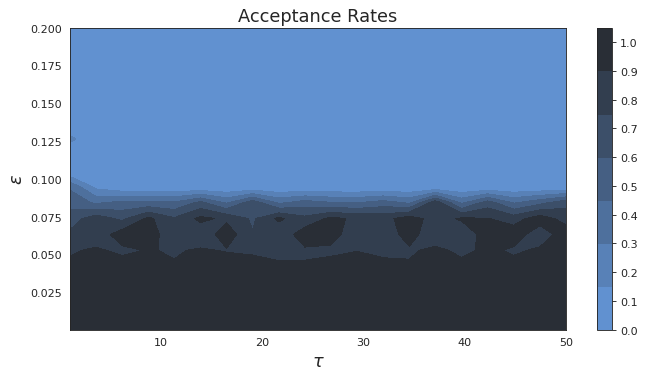

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (10, 5), dpi=80)
ax.set_title(r'Acceptance Rates', fontsize=16)
cp = ax.contourf(taus, epsilons, acceptance_rates.T, cmap=cmap);
fig.colorbar(cp, ticks=np.arange(0,1.1,0.1)) # Add a colorbar to a plot
ax.set_xlabel(r'$\tau$', fontsize=16)
ax.set_ylabel(r'$\varepsilon$', fontsize=16);

Accuracy as a function of computation time

In [ ]:
samples_t = {}
total_time = 0.5

samples_t['nHMC'], _, _ = hamiltonian_monte_carlo(num_samples, stats.uniform.rvs(size=2), findE, gradE=gradE,  tau=19, epsilon=0.055, mu=0, sigma=1, timing=True, minutes=total_time)

samples_t['aHMC'], _, _ = hamiltonian_monte_carlo(num_samples, stats.uniform.rvs(size=2), findE, gradE=AgradE, tau=19, epsilon=0.055, mu=0, sigma=1, timing=True, minutes=total_time)

In [ ]:
samples, _, _ = metropolis(Px, sigmas=np.array([1.5, 1.5]), R=2, iterations=1000, timing=True, minutes=total_time)

samplesMH = [list(samples[i]) for i in range(len(samples))]

samples_t['MH'] = samplesMH

yes


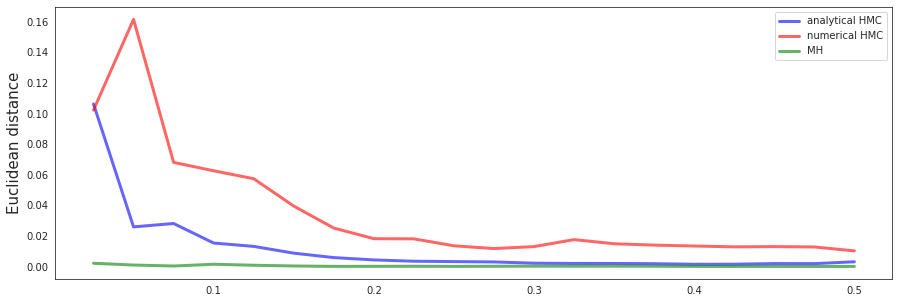

In [ ]:
steps = 20
n_smp_an = len(samples_t['aHMC'])
n_smp_num = len(samples_t['nHMC'])
n_smp_mh = len(samples_t['MH'])


fig, ax = plt.subplots(1, 1, figsize=(15,5))

mean_t = []
for i in range(steps):
  mean_t.append(np.mean(samples_t['aHMC'][:int(np.ceil(n_smp_an * (i + 1) / steps))], axis=0))
dist_t = np.sum(np.power(mean_t, 2), axis=1)
ax.plot(np.linspace(0, total_time, steps + 1)[1:], dist_t, 'b-', lw=3, alpha=0.6, label='analytical HMC');

mean_t = []
for i in range(steps):
  mean_t.append(np.mean(samples_t['nHMC'][:int(np.ceil(n_smp_num * (i + 1) / steps))], axis=0))
dist_t = np.sum(np.power(mean_t, 2), axis=1)
ax.plot(np.linspace(0, total_time, steps + 1)[1:], dist_t, 'r-', lw=3, alpha=0.6, label='numerical HMC');

mean_t = []
for i in range(steps):
  mean_t.append(np.mean(samples_t['MH'][:int(np.ceil(n_smp_mh * (i + 1) / steps))], axis=0))
dist_t = np.sum(np.power(mean_t, 2), axis=1)
ax.plot(np.linspace(0, total_time, steps + 1)[1:], dist_t, 'g-', lw=3, alpha=0.6, label='MH');


ax.set_ylabel('Euclidean distance', fontsize=15);
#ax.axhline(y=0, c='k', label=r'Actual $\mu$ with $$')
ax.legend();